# Anomaly Detection in Bipartite Graphs - Model Comparison

This notebook compares different models for anomaly detection in bipartite graphs.

In [1]:
# Load the extension
%load_ext autoreload
# Configure it to reload all modules before each cell execution
%autoreload 2

In [12]:
import sys
import os
sys.path.append('..')

# --- MPS Fallback ---
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
print(f"PYTORCH_ENABLE_MPS_FALLBACK set to: {os.environ.get('PYTORCH_ENABLE_MPS_FALLBACK')}")

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch_geometric.transforms as T
from sklearn.metrics import precision_recall_curve

# Import custom modules
from src.data.dataloader import load_member_features, load_provider_features, load_claims_data, prepare_hetero_data
from src.data.anomaly_injection import  * 
from src.models.main_model import *
from src.models.baseline_models import MLPAutoencoder, SklearnBaseline, GCNAutoencoder, GATAutoencoder, SAGEAutoencoder
from src.utils.vizualize import *
from src.utils.train_utils import *
from src.utils.eval_utils import *
from src.utils.stat_utils import *

PYTORCH_ENABLE_MPS_FALLBACK set to: 1


## 1. Load and Prepare Data

In [3]:
df_member_features, members_dataset = load_member_features("../data/final_members_df.pickle")
df_provider_features, providers_dataset = load_provider_features("../data/final_df.pickle")
df_edges = load_claims_data("../data/df_descriptions.pickle", members_dataset=members_dataset, providers_dataset=providers_dataset)

print(f"Members: {len(members_dataset)}")
print(f"Providers: {len(providers_dataset)}")
print(f"Edges: {len(df_edges)}")

print("\nMember features:")
display(df_member_features.head())
print("\nProvider features:")
display(df_provider_features.head())
print("\nEdges:")
display(df_edges.head())

Members: 32560
Providers: 652
Edges: 58996

Member features:


,mean_claim_period,median_claim_period,min_claim_period,max_claim_period,std_claim_period,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,...,avg_provider_claim_amount,unique_providers,num_claims,prop_claimtype_not_op,prop_claimtype_out-patient,single_interaction_ratio,gender_f,gender_m,principalcode_dependant,principalcode_principal
membercode,,,,,,,,,,,,,,,,,,,,,
589143,-0.304701,-0.212336,-0.315465,-0.051256,-0.674128,0.660569,0.483461,1.201042,0.967073,0.588056,...,0.320333,0.000000,1.906891,0.0,1.0,0.071429,1.0,0.0,0.0,1.0
589150,0.136534,0.267512,0.315465,0.337099,-0.044980,0.693704,0.060593,-0.461668,1.389210,0.919456,...,0.662848,2.089694,2.247928,0.0,1.0,0.111111,1.0,0.0,0.0,1.0
589151,0.000000,0.000000,0.000000,0.000000,0.000000,0.558524,0.686361,-0.390630,0.442232,0.667439,...,0.532630,0.000000,-0.415037,0.0,1.0,1.000000,0.0,1.0,1.0,0.0
589152,-0.665389,-0.362991,0.184535,-0.696713,-1.862060,0.008422,-0.130645,-0.502561,0.214536,0.247757,...,0.330445,0.000000,0.321928,0.0,1.0,0.250000,0.0,1.0,1.0,0.0
589154,1.468108,1.755317,2.210028,1.002648,0.000000,-0.022566,0.373619,0.292756,-0.233386,-0.145385,...,0.035693,0.000000,0.000000,0.0,1.0,0.333333,0.0,1.0,0.0,1.0



Provider features:


,one_hot_claim__finalstatus_infrequent_sklearn,one_hot_claim__claimtype_infrequent_sklearn,one_hot_claim__loastatus_infrequent_sklearn,one_hot_claim__roomtype_infrequent_sklearn,one_hot_claim__principalcode_principal,one_hot_claim__casetype_reimbursement,one_hot_claim__gender_m,one_hot_provider__providertype_clinic,one_hot_provider__providertype_hospital,one_hot_provider__providertype_infrequent_sklearn,...,std_member_claim_amount,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,single_interaction_ratio,num_members,num_claims,hdbscan_cluster_from_semantics
providercode,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.062780,0.008969,0.0,0.349776,0.067265,0.399103,0.0,1.0,0.0,...,0.524022,0.321360,0.050260,-0.262126,0.966920,0.789321,-0.449752,0.563258,0.548708,1
17,0.0,0.000000,0.000000,0.0,0.472222,0.083333,0.333333,1.0,0.0,0.0,...,0.537356,0.474466,0.675916,0.763060,-0.215126,-0.003480,1.110301,-0.277891,-0.568451,1
53,0.0,0.008342,0.005214,0.0,0.662148,0.020855,0.344108,0.0,1.0,0.0,...,-0.393823,-0.617874,-0.583296,-0.231640,0.285726,-0.109757,-0.722677,1.375164,1.451557,1
54,0.0,0.007160,0.004773,0.0,0.625298,0.026253,0.436754,1.0,0.0,0.0,...,-0.328537,-0.548802,-0.583296,-0.440637,0.323048,-0.065129,-0.578037,0.911511,0.938692,1
76,0.0,0.175573,0.000000,0.0,0.694656,0.045802,0.580153,0.0,1.0,0.0,...,0.851399,1.081335,0.571845,0.456543,0.548513,0.721966,0.413834,0.404467,0.220617,1



Edges:


,provider_id,member_id,nbr_claims
3,4,589264,3
4,4,905121,1
6,4,905123,2
7,4,905144,2
8,4,905146,2


In [4]:
# Create HeteroData object
data = prepare_hetero_data(df_member_features, df_provider_features, df_edges)

print(data)
print(f"Member features shape: {data['member'].x.shape}")
print(f"Provider features shape: {data['provider'].x.shape}")
print(f"Number of edges: {data['provider', 'to', 'member'].edge_index.shape[1]}")

HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 58996],
    edge_attr=[58996, 1],
  },
  (member, to, provider)={
    edge_index=[2, 58996],
    edge_attr=[58996, 1],
  }
)
Member features shape: torch.Size([32560, 23])
Provider features shape: torch.Size([652, 38])
Number of edges: 58996


## 2. Inject Synthetic Anomalies for Evaluation

### 2.1 Injection function

In [5]:
original_data = data.clone()

# Inject anomalies using the simplified function
modified_data, gt_node_labels, gt_edge_labels, final_anomaly_tracking = inject_simplified_anomalies(
    data=original_data,
)

anomaly_data = modified_data 

Injecting 30 anomalies:
  Structural: 10
  Attribute: 10
  Combined: 10
Anomaly injection finished.


### 2.2 Analyzing data after injection

--- Anomaly Injection Analysis ---

--- Analyzing Node Type: member ---
  Total Nodes: 32560
  Anomalous Nodes: 354 (1.09%)
  Anomaly Type Component Counts (Node Level):
    - node_feature_relative: 228
    - structural: 127
    - attribute: 115
    - combined: 113
    - edge_feature_scaled: 107
    - edge_feature_outside: 106
    - structural_block: 20
  Primary Injection Type Counts (Node Level):
    - structural: 127
    - attribute: 115
    - combined: 113
  Average Degree (Normal vs Anomalous):
    - Avg. Degree (in_provider): Normal=1.81, Anomalous=7.82
    - Avg. Degree (out_provider): Normal=1.81, Anomalous=7.82
  Generating Feature Plot for member...
    Applying PCA (2 components)...


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.co

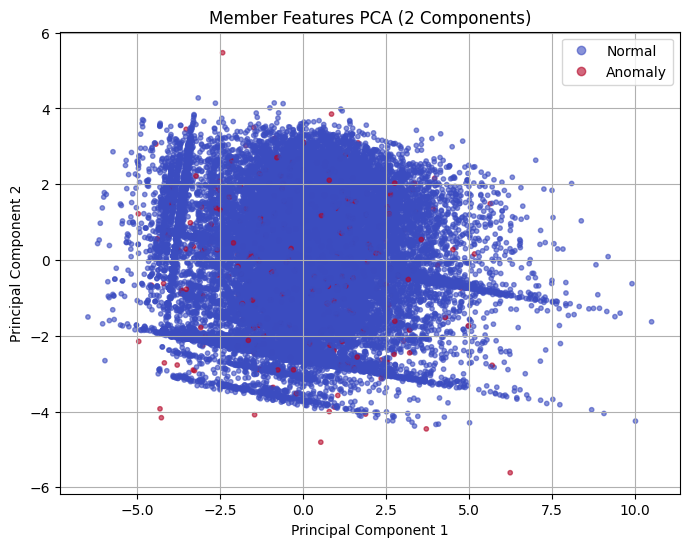


--- Analyzing Node Type: provider ---
  Total Nodes: 652
  Anomalous Nodes: 237 (36.35%)
  Anomaly Type Component Counts (Node Level):
    - node_feature_relative: 152
    - structural: 113
    - combined: 91
    - edge_feature_outside: 80
    - edge_feature_scaled: 78
    - attribute: 73
    - structural_block: 20
  Primary Injection Type Counts (Node Level):
    - structural: 113
    - combined: 91
    - attribute: 73
  Average Degree (Normal vs Anomalous):
    - Avg. Degree (out_member): Normal=77.88, Anomalous=121.53
    - Avg. Degree (in_member): Normal=77.88, Anomalous=121.53
  Generating Feature Plot for provider...
    Applying PCA (2 components)...


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.co

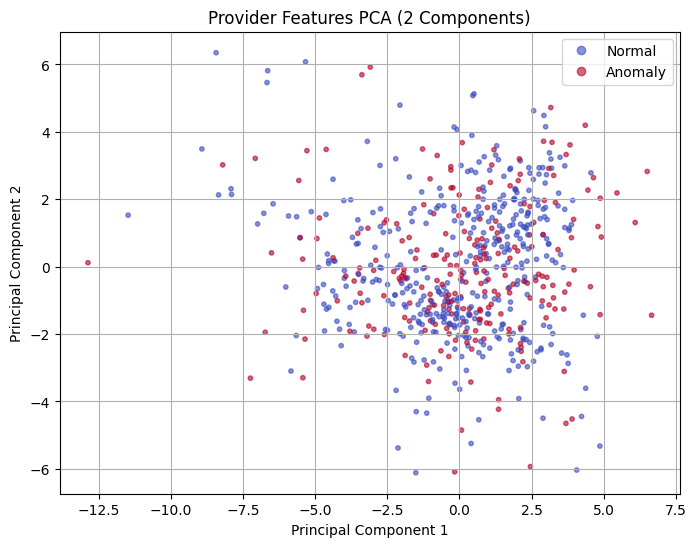


--- Analyzing Edges ---
  Edge Type: ('provider', 'to', 'member')
    Total Edges: 61123
    Anomalous Edges (Injected): 2127 (3.48%)
  Edge Type: ('member', 'to', 'provider')
    Total Edges: 61123
    Anomalous Edges (Injected): 2127 (3.48%)

--- Analysis Complete ---

--- Anomaly Summary ---


,Count
member_total,32560
member_anomalous,354
provider_total,652
provider_anomalous,237
"('provider', 'to', 'member')_total",61123
"('provider', 'to', 'member')_anomalous",2127
"('member', 'to', 'provider')_total",61123
"('member', 'to', 'provider')_anomalous",2127


In [6]:
analysis_summary_df = analyze_injected_anomalies(
    data=anomaly_data,
    gt_node_labels=gt_node_labels,
    anomaly_tracking=final_anomaly_tracking,
    original_data=original_data, # Optional
    gt_edge_labels=gt_edge_labels, # Pass the edge labels
    plot_features=True
)

print("\n--- Anomaly Summary ---")
display(analysis_summary_df)

### 2.3 Vizualizing data after injection

In [7]:
vis_net_anom = visualize_anomalous_subgraph(
    data=anomaly_data, # Data with anomalies
    gt_node_labels=gt_node_labels,
    anomaly_tracking=final_anomaly_tracking,
    num_anomalous_providers=15, # Adjust sample sizes
    num_anomalous_members=30,
    context_neighbors=3,
    filename='anomalous_subgraph_viz.html'
)
# Display in notebook if needed:
#from IPython.display import HTML
#HTML(filename='anomalous_subgraph_viz.html')

Visualizing anomalous subgraph...
Saving visualization to anomalous_subgraph_viz.html


In [8]:
vis_net_general = visualize_graph_with_anomaly_info(
    data=anomaly_data,
    gt_node_labels=gt_node_labels,
    anomaly_tracking=final_anomaly_tracking,
    gt_edge_labels=gt_edge_labels, # Pass the edge labels dict
    target_edge_type=('provider', 'to', 'member'),
    sample_size_provider=50,  # Adjust sample size
    max_members_per_provider=5, # Adjust density control
    filename='general_graph_viz_updated.html'
)

Generating visualization for general_graph_viz_updated.html...
Sampled 50 providers and 250 members.
Added 269 edges to the visualization.
Saving visualization to general_graph_viz_updated.html


## 3. Define Models to Compare

### 3.1 Main model 

In [9]:
# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [10]:
# Move data to device (do this once here)
print(f"Moving data to device: {device}")
# Use the data with injected anomalies
data_on_device = anomaly_data.to(device)
# Also move ground truth labels (needed for validation during training)
gt_node_labels_on_device = {k: v.to(device) for k, v in gt_node_labels.items()}
# gt_edge_labels can stay on CPU or move if needed later, evaluation happens on CPU usually

# --- Model Hyperparameters ---
# Set dimensions based on data
in_dim_member = data_on_device['member'].x.size(1)
in_dim_provider = data_on_device['provider'].x.size(1)
hidden_dim = 128 # Example: Increased capacity
latent_dim = 64  # Example: Increased capacity

# Check if edge_attr exists and get its dimension
target_edge_type_for_dim = ('provider', 'to', 'member')
if hasattr(data_on_device[target_edge_type_for_dim], 'edge_attr') and data_on_device[target_edge_type_for_dim].edge_attr is not None:
    edge_dim = data_on_device[target_edge_type_for_dim].edge_attr.size(1)
    print(f"Edge dimension (edge_dim) detected as: {edge_dim}")
else:
    edge_dim = 0 # Or handle as error if edge attributes are expected
    print("Warning: No edge_attr found for target edge type. Setting edge_dim=0.")

num_conv_layers = 2
num_dec_layers = 2
dropout_rate = 0.5 # Example

# --- Instantiate the Main Model ---
# This will be the single model instance we train and evaluate
bgae_model = BipartiteGraphAutoEncoder_ReportBased(
    in_dim_member=in_dim_member,
    in_dim_provider=in_dim_provider,
    edge_dim=edge_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    num_conv_layers=num_conv_layers,
    num_dec_layers=num_dec_layers,
    dropout=dropout_rate
).to(device)

print("\nBipartite GAE Model Instantiated:")
print(bgae_model) # Optional: Print model structure

# --- Optimizer Definition ---
learning_rate = 5e-4 # Example LR
weight_decay = 1e-5  # Example L2 regularization
optimizer = torch.optim.Adam(bgae_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print("\nOptimizer Defined.")

Moving data to device: mps
Edge dimension (edge_dim) detected as: 1

Bipartite GAE Model Instantiated:
BipartiteGraphAutoEncoder_ReportBased(
  (proj_member): Linear(in_features=23, out_features=128, bias=True)
  (proj_provider): Linear(in_features=38, out_features=128, bias=True)
  (convs): ModuleList(
    (0-1): 2 x HeteroConv(num_relations=2)
  )
  (final_member): Linear(in_features=128, out_features=64, bias=True)
  (final_provider): Linear(in_features=128, out_features=64, bias=True)
  (dec_member): AttributeDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=23, bias=True)
    )
  )
  (dec_provider): AttributeDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=38, bias=True)
  

## 4. Train and Evaluate Models

--- Splitting Edges for Train/Validation/Test ---
Restoring node features to splits...
Train Data Sample: HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 48899],
    edge_attr=[48899, 1],
    y=[48899],
    edge_label=[48899],
    edge_label_index=[2, 48899],
  },
  (member, to, provider)={
    edge_index=[2, 48899],
    edge_attr=[48899, 1],
    y=[48899],
  }
)
Validation Data Sample: HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 48899],
    edge_attr=[48899, 1],
    y=[48899],
    edge_label=[12224],
    edge_label_index=[2, 12224],
  },
  (member, to, provider)={
    edge_index=[2, 48899],
    edge_attr=[48899, 1],
    y=[48899],
  }
)
Test Data Sample: HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 55011],
    edge_attr=[55011, 1],
    y=[55011],
    edge_label=[12224],
    edge_labe

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch_geometric/utils/_scatter.py:102: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(


Epoch 10/100 | Train Loss: 4.3088 | Val Loss: 3.0806 | Val AUC(P/M): 0.7365/0.8069 | Val AP(P/M): 0.5914/0.0875
Epoch 20/100 | Train Loss: 3.3962 | Val Loss: 3.1777 | Val AUC(P/M): 0.7351/0.8189 | Val AP(P/M): 0.5884/0.0981
Epoch 30/100 | Train Loss: 3.0032 | Val Loss: 2.9769 | Val AUC(P/M): 0.7407/0.8218 | Val AP(P/M): 0.6012/0.1034
Epoch 40/100 | Train Loss: 2.6252 | Val Loss: 2.7016 | Val AUC(P/M): 0.7497/0.8210 | Val AP(P/M): 0.6264/0.1057
Epoch 50/100 | Train Loss: 2.5134 | Val Loss: 2.6855 | Val AUC(P/M): 0.7527/0.8287 | Val AP(P/M): 0.6404/0.1159
Epoch 60/100 | Train Loss: 2.3416 | Val Loss: 2.5721 | Val AUC(P/M): 0.7576/0.8324 | Val AP(P/M): 0.6564/0.1269
Epoch 70/100 | Train Loss: 2.2080 | Val Loss: 2.5443 | Val AUC(P/M): 0.7598/0.8398 | Val AP(P/M): 0.6640/0.1436
Epoch 80/100 | Train Loss: 2.1190 | Val Loss: 2.4745 | Val AUC(P/M): 0.7635/0.8462 | Val AP(P/M): 0.6746/0.1674
Epoch 90/100 | Train Loss: 1.9847 | Val Loss: 2.4116 | Val AUC(P/M): 0.7679/0.8534 | Val AP(P/M): 0.6853

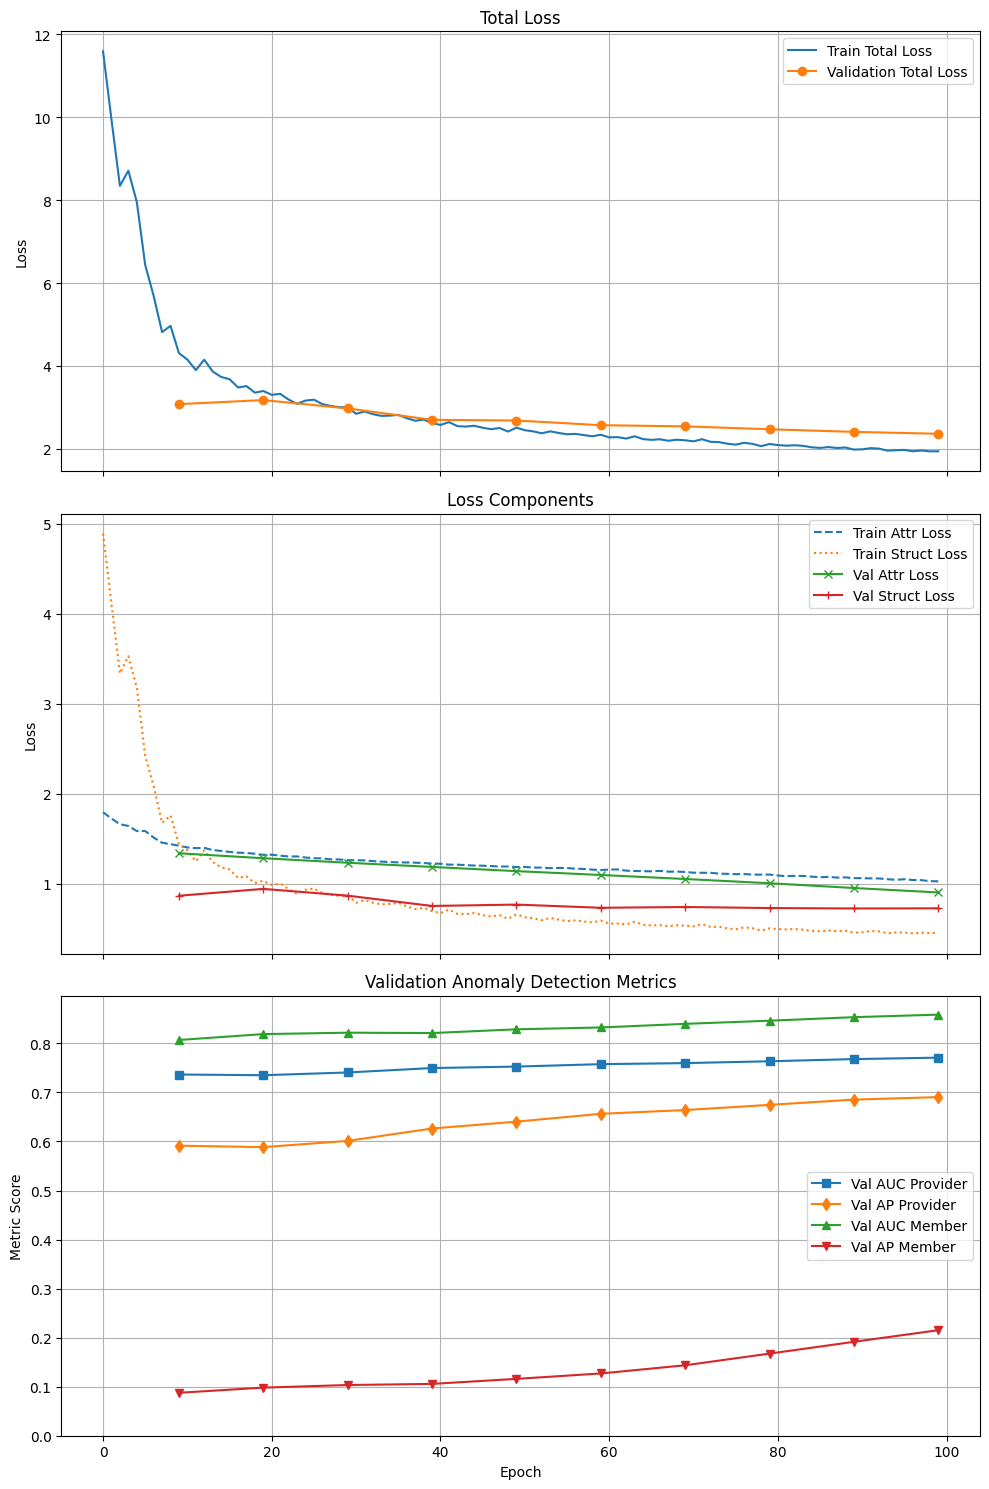


--- Starting Final Evaluation ---

--- Evaluating on Validation Set ---

Validation Results:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
provider,0.707437,0.574093,0.68,0.143460,0.58,0.244726,0.545,0.459916,0.430,0.907173,0.609865,99.087791
member,0.958232,0.599757,1.00,0.141243,0.90,0.254237,0.770,0.435028,0.458,0.646893,0.602484,41.772331



--- Evaluating on Test Set ---

Test Results:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
provider,0.707437,0.574093,0.68,0.143460,0.58,0.244726,0.545,0.459916,0.430,0.907173,0.609865,99.087799
member,0.958232,0.599757,1.00,0.141243,0.90,0.254237,0.770,0.435028,0.458,0.646893,0.602484,41.772331


In [13]:
# --- 1. Split Edges for Structure Evaluation ---
print("--- Splitting Edges for Train/Validation/Test ---")
# Use the data that has anomalies injected
data_to_split = anomaly_data.clone() # Clone to prevent modifying the main anomaly_data object
target_edge_type = ('provider', 'to', 'member')
reverse_edge_type = ('member', 'to', 'provider') # Define if used by splitter

# Check if reverse edge type exists before passing it
rev_edge_types_arg = reverse_edge_type if reverse_edge_type in data_to_split.edge_types else None

edge_splitter = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    add_negative_train_samples=False, # We handle negative sampling in the loop
    edge_types=[target_edge_type], # Specify edge type(s) to split
    rev_edge_types = [rev_edge_types_arg] if rev_edge_types_arg else None # Pass reverse type if exists
)

train_data, val_data, test_data = edge_splitter(data_to_split.to(device))

# Restore necessary attributes (like node features 'x') if dropped by splitter
# Important: RandomLinkSplit primarily modifies edge_index and adds edge_label info.
# Node features should ideally be preserved, but we copy them just in case.
print("Restoring node features to splits...")
for split in [train_data, val_data, test_data]:
    for node_type in data_to_split.node_types:
        if hasattr(data_to_split[node_type], 'x'):
            split[node_type].x = data_to_split[node_type].x
    # We don't restore edge_attr here, as RandomLinkSplit modifies edges.
    # The model's BipartiteAttentionConv handles missing edge_attr if edge_dim=0.
    # If edge_dim > 0, ensure the original `anomaly_data` passed to training/eval has it.

print("Train Data Sample:", train_data)
print("Validation Data Sample:", val_data)
print("Test Data Sample:", test_data)


# --- 2. Train and Validate the Model ---
print("\n--- Starting Training & Validation ---")
# Make sure the train_and_validate_model function is defined above

# Define training hyperparameters
num_epochs = 100 # ADJUST AS NEEDED (start lower, increase based on plots)
train_lambda_attr = 1.0
train_lambda_struct = 2.0 # TUNABLE PARAMETER (Increased based on previous analysis)
k_neg = 5
eval_freq = 10 # Evaluate on validation set every 10 epochs

# --- Ensure necessary variables exist ---
# bgae_model, optimizer, gt_node_labels_on_device, device
# train_data, val_data
# ---

history = train_and_validate_model(
    model=bgae_model, # Use the instantiated model
    train_data=train_data,
    val_data=val_data,
    gt_labels=gt_node_labels_on_device, # Pass ground truth node labels (on device)
    num_epochs=num_epochs,
    optimizer=optimizer,
    lambda_attr=train_lambda_attr,
    lambda_struct=train_lambda_struct,
    k_neg_samples=k_neg,
    target_edge_type=target_edge_type,
    eval_freq=eval_freq,
    device=device,
    plot=True # Show plots after training
)

# --- 3. Final Evaluation on Validation and Test Sets ---
print("\n--- Starting Final Evaluation ---")

# --- Run Evaluation ---
k_values_for_eval = [50, 100, 200, 500] # Adjust as needed

# Evaluate on Validation Set
print("\n--- Evaluating on Validation Set ---")
val_results, val_scores = evaluate_model_with_scores(
    model=bgae_model, # Use the *trained* model
    data_split=val_data,
    train_data_struct=train_data,
    gt_labels=gt_node_labels_on_device, # Pass original GT labels
    lambda_attr=train_lambda_attr, # Use same lambdas for scoring
    lambda_struct=train_lambda_struct,
    k_list=k_values_for_eval
)
print("\nValidation Results:")
val_results_df = pd.DataFrame(val_results).T
display(val_results_df)

# Evaluate on Test Set
print("\n--- Evaluating on Test Set ---")
test_results, test_scores = evaluate_model_with_scores(
    model=bgae_model, # Use the *trained* model
    data_split=test_data,
    train_data_struct=train_data,
    gt_labels=gt_node_labels_on_device, # Pass original GT labels
    lambda_attr=train_lambda_attr,
    lambda_struct=train_lambda_struct,
    k_list=k_values_for_eval
)
print("\nTest Results:")
test_results_df = pd.DataFrame(test_results).T
display(test_results_df)

# --- Store results for Section 5 ---
# Store in a structure compatible with later analysis/plotting
final_results_bgae = {
    "validation": val_results,
    "test": test_results
}
final_scores_bgae = {
    "validation": val_scores,
    "test": test_scores
}

# Comment out or remove the old loop and evaluation calls
# all_results = {}
# for name, model in models.items(): ...

## 5. Compare Results

--- Running Final Evaluation with Updated Function ---

--- Evaluating on Validation Set ---
Running forward pass for evaluation...
Calculating NODE anomaly scores...
Computing NODE metrics...
Calculating EDGE anomaly scores/logits...
  Computing EDGE metrics for ('provider', 'to', 'member')...
    Edges: 48899, Anomalies: 1706
  Computing EDGE metrics for ('member', 'to', 'provider')...
    Edges: 48899, Anomalies: 1706

Validation Node Results:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
provider,0.772386,0.707925,0.82,0.172996,0.85,0.358650,0.735,0.620253,0.418,0.881857,0.675737,20.982635
member,0.747981,0.064710,0.22,0.031073,0.16,0.045198,0.130,0.073446,0.106,0.149718,0.141155,34.681248



Validation Edge Results:


,,,AUROC,AP,Best F1,Best F1 Threshold
provider,to,member,0.882767,0.234553,0.313156,3.12145
member,to,provider,0.497582,0.035281,0.068919,-0.00000



--- Evaluating on Test Set ---
Running forward pass for evaluation...
Calculating NODE anomaly scores...
Computing NODE metrics...
Calculating EDGE anomaly scores/logits...
  Computing EDGE metrics for ('provider', 'to', 'member')...
    Edges: 55011, Anomalies: 1928
  Computing EDGE metrics for ('member', 'to', 'provider')...
    Edges: 55011, Anomalies: 1928

Test Node Results:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
provider,0.772304,0.708143,0.82,0.172996,0.85,0.358650,0.735,0.620253,0.416,0.877637,0.674208,21.037823
member,0.746701,0.064918,0.26,0.036723,0.16,0.045198,0.130,0.073446,0.102,0.144068,0.140897,34.587456



Test Edge Results:


,,,AUROC,AP,Best F1,Best F1 Threshold
provider,to,member,0.878068,0.212400,0.297169,2.982218
member,to,provider,0.499405,0.035628,0.069523,-0.000000



--- Plotting Evaluation Curves (Test Set) ---


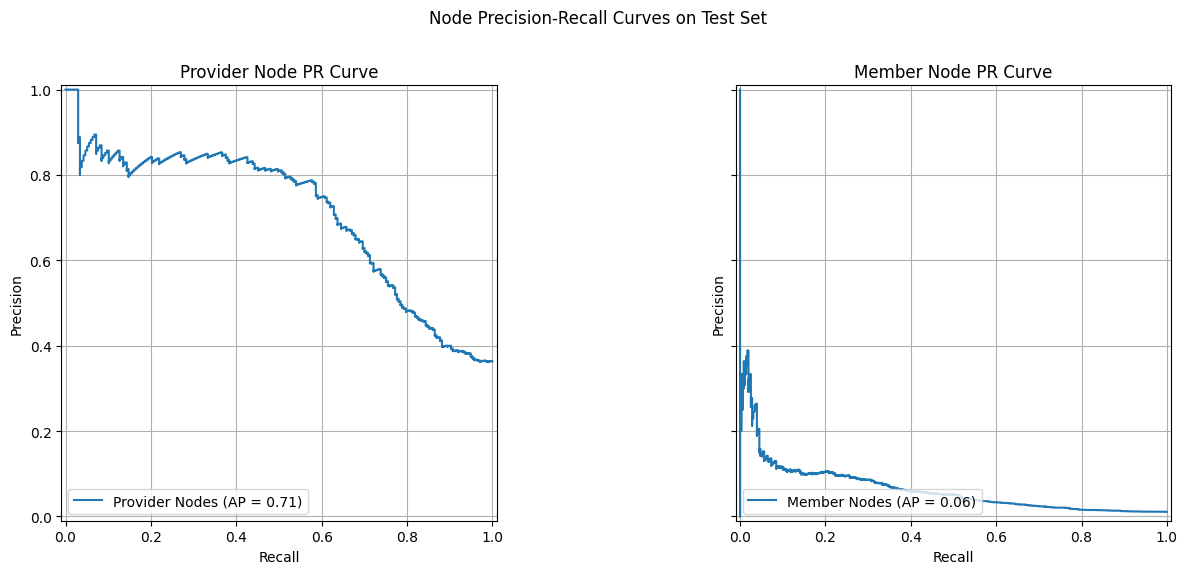


--- Plotting Edge Score Distribution (('provider', 'to', 'member')) ---


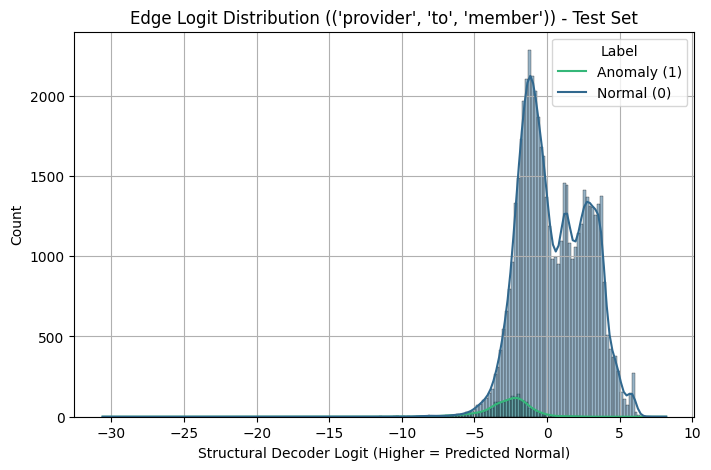

In [14]:
# %% [markdown]
# ## 5. Analyze and Visualize Results (Updated)

# %%
# --- Ensure these variables are defined from previous cells ---
# bgae_model (the trained model)
# train_data, val_data, test_data
# gt_node_labels (original node GT labels)
# gt_edge_labels (original edge GT labels, potentially stored in data splits as .y)
# train_lambda_attr, train_lambda_struct (used for training/scoring)
# ---

print("--- Running Final Evaluation with Updated Function ---")
k_values_for_eval = [50, 100, 200, 500] # K values for node P@K, R@K

# Evaluate on Validation Set
print("\n--- Evaluating on Validation Set ---")
val_node_results, val_edge_results, val_node_scores, val_edge_scores = evaluate_model_performance(
    model=bgae_model,
    eval_data=val_data, # Pass validation split
    train_data_struct=train_data,
    gt_node_labels=gt_node_labels_on_device, # Node labels
    lambda_attr=train_lambda_attr,
    lambda_struct=train_lambda_struct,
    target_edge_types_eval=[('provider', 'to', 'member'), ('member', 'to', 'provider')], # Evaluate both directions if available
    k_list=k_values_for_eval
)
print("\nValidation Node Results:")
val_node_results_df = pd.DataFrame(val_node_results).T
display(val_node_results_df)
print("\nValidation Edge Results:")
val_edge_results_df = pd.DataFrame(val_edge_results).T
display(val_edge_results_df)


# Evaluate on Test Set
print("\n--- Evaluating on Test Set ---")
test_node_results, test_edge_results, test_node_scores, test_edge_scores = evaluate_model_performance(
    model=bgae_model,
    eval_data=test_data, # Pass test split
    train_data_struct=train_data,
    gt_node_labels=gt_node_labels_on_device, # Node labels
    lambda_attr=train_lambda_attr,
    lambda_struct=train_lambda_struct,
    target_edge_types_eval=[('provider', 'to', 'member'), ('member', 'to', 'provider')], # Evaluate both directions
    k_list=k_values_for_eval
)
print("\nTest Node Results:")
test_node_results_df = pd.DataFrame(test_node_results).T
display(test_node_results_df)
print("\nTest Edge Results:")
test_edge_results_df = pd.DataFrame(test_edge_results).T
display(test_edge_results_df)


# --- Plotting (Example: Node PR Curves & Edge AUC/AP) ---
print("\n--- Plotting Evaluation Curves (Test Set) ---")
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Plot Node PR Curves (similar to before, using test_node_scores)
fig_pr_node, axes_pr_node = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
if 'provider' in test_node_results and 'provider' in test_node_scores:
    # Use node scores and gt_node_labels
    scores_p = test_node_scores['provider'].cpu().numpy()
    labels_p = gt_node_labels['provider'].cpu().numpy()
    if len(np.unique(labels_p)) > 1:
        precision, recall, _ = precision_recall_curve(labels_p, scores_p)
        ap_p = test_node_results['provider'].get('AP', 0)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap_p)
        disp.plot(ax=axes_pr_node[0], name='Provider Nodes')
    axes_pr_node[0].set_title('Provider Node PR Curve')
    axes_pr_node[0].grid(True); axes_pr_node[0].set_ylim(bottom=0.0, top=1.05)

if 'member' in test_node_results and 'member' in test_node_scores:
    # Use node scores and gt_node_labels
    scores_m = test_node_scores['member'].cpu().numpy()
    labels_m = gt_node_labels['member'].cpu().numpy()
    if len(np.unique(labels_m)) > 1:
        precision, recall, _ = precision_recall_curve(labels_m, scores_m)
        ap_m = test_node_results['member'].get('AP', 0)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap_m)
        disp.plot(ax=axes_pr_node[1], name='Member Nodes')
    axes_pr_node[1].set_title('Member Node PR Curve')
    axes_pr_node[1].grid(True)

plt.suptitle("Node Precision-Recall Curves on Test Set")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Plot Edge Score Distributions (Example for target_edge_type)
target_plot_edge_type = ('provider', 'to', 'member')
if target_plot_edge_type in test_edge_scores and hasattr(test_data[target_plot_edge_type], 'y'):
    print(f"\n--- Plotting Edge Score Distribution ({target_plot_edge_type}) ---")
    # Remember scores are logits (higher=normal), labels are 0/1 (1=anomaly)
    edge_scores_plot = test_edge_scores[target_plot_edge_type] # logits
    edge_labels_plot = test_data[target_plot_edge_type].y.cpu().numpy()

    df_edge = pd.DataFrame({'logit': edge_scores_plot, 'label': edge_labels_plot})
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_edge, x='logit', hue='label', kde=True, palette='viridis')
    plt.title(f'Edge Logit Distribution ({target_plot_edge_type}) - Test Set')
    plt.xlabel('Structural Decoder Logit (Higher = Predicted Normal)')
    plt.legend(title='Label', labels=['Anomaly (1)', 'Normal (0)']) # Adjust labels if needed
    plt.grid(True)
    plt.show()

## 6. Analysis and Conclusion

Based on the results above, we can draw the following conclusions:

1. **Performance Comparison**: [Your analysis based on the results]
2. **Strengths and Weaknesses**: [Discuss strengths/weaknesses of different models]
3. **Recommended Model**: [Which model performed best and why]
4. **Future Work**: [Suggestions for improvements]